## Analyzing AQI after the Thomas Fire
Annie Adams 

Link to github : https://github.com/annieradams/eds220-hwk4-project-repo/

# About 

### Import Packages and the Data

In [ ]:
#import necessary packages

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches # for creating legends
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize #for reasterizing polygons
import matplotlib.lines as mlines

In [5]:
#read in aqi data for 2017 and 2018
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip') # 2017 data
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip') # 2018 data

# read in shapefile of califronia fire/ perimters
ca_fire = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp') 

#read in landsat data
landsat_fp = os.path.join(os.getcwd(), 'data','landsat8-2018-01-26-sb-simplified.nc') 
landsat = rioxr.open_rasterio(landsat_fp)


## Geographical Context of Data
*Select data pertaining to area of interest (Santa Barbara)*

In [16]:
 # concatenate 2017 and 2018 data using concat to get one dataframe for all aqi data
aqi = pd.concat([aqi_17, aqi_18])

#only select data in Santa barbara since that is where Thomas fire was 
aqi_sb = aqi[aqi["county Name"] == "Santa Barbara"].drop(columns = ['State Name','county Name','State Code','County Code']) #select Santa barbara and drop unnecessary columns

#only select thomas fire perimeter
thomas_fire = ca_fire[ca_fire.FIRE_NAME == "THOMAS"]


## Data Exploration
Explore information on all three datasets to understand data setup



###### **Aqi dataset**

In [26]:
print("Number of unique values : \n", aqi_sb.nunique(), "\n") # check number of unique values to get idea on variety of data
print("Column datatypes:\n ", aqi_sb.dtypes, "\n")  # check data types of variables for future reference
print("Shape of data:", aqi_sb.shape) # check shape of data to see how many columns and observations there are

Number of unique values : 
 Date                         730
AQI                           75
Category                       5
Defining Parameter             3
Defining Site                 12
Number of Sites Reporting      4
dtype: int64 

Column datatypes:
  Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object 

Shape of data: (730, 6)


###### **CA fire perimter shapefile**

In [35]:
print("Column names: \n", ca_fire.columns) # check column names to see what the data contains
print("Shape of data:", ca_fire.shape,"\n") # check shape of data to see how many columns and observations there are
print("Column datatypes:\n ", ca_fire.dtypes, "\n")  # check data types of variables for future reference

Column names: 
 Index(['index', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'COMPLEX_IN', 'IRWINID',
       'FIRE_NUM', 'DECADES', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')
Shape of data: (608, 23) 

Column datatypes:
  index            int64
OBJECTID         int64
YEAR_           object
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE          float64
C_METHOD       float64
OBJECTIVE      float64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
COMPLEX_IN      object
IRWINID         object
FIRE_NUM        object
DECADES         object
SHAPE_Leng     float64
SHAPE_Area     float64
geometry      geometry
dtype: object 



###### **Landsat data**

In [37]:
print("The dimmensions of the landsat data are:\n", landsat.dims,"\n") # check file dimmensions
print("The coordinates of the landsat data are:\n", landsat.coords,"\n") # check coordinates of shapefile
print("The values of the landsat data are:\n",  landsat.values, "\n") # values of xarray
print("The crs of the landsat data is:", landsat.rio.crs) # check crs

The dimmensions of the landsat data are:
 Frozen({'y': 731, 'x': 870, 'band': 1}) 

The coordinates of the landsat data are:
 Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0 

The values of the landsat data are:
 <bound method Mapping.values of <xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...> 

The crs of the landsat data is: EPSG:32611


## Data Cleaning

###### **Aqi dataset**

In [39]:
aqi_sb.columns = aqi_sb.columns.str.lower() #make column names lower case
aqi_sb.columns = aqi_sb.columns.str.replace(' ','_') # reassign column names by substituting an underscore for a space
aqi_sb.date = pd.to_datetime(aqi_sb.date) # update data column to datetime
aqi_sb = aqi_sb.set_index('date') # change index to be date

###### **Landsat data**

In [41]:
# drop band dimension to make data 2D
landsat_2d = landsat.squeeze().drop('band')
landsat_2d # check to make sure band is no longer included

###### **CA fire perimter shapefile**

In [42]:
thomas_fire= thomas_fire.to_crs(landsat_2d.rio.crs) # change crs of thomas fire to match landsat crs

In [46]:
#check to make sure crs' match/
thomas_fire.crs == landsat.rio.crs

True

## Data Analysis

##### Analyze AQI Values in data to see if AQI spikes are present during Thomas Fire
Plot five day average of aqi and daily aqi 

<AxesSubplot:title={'center':'AQI and Five day AQI Average in Santa Barbara County from Jan 2017 to December 2018'}, xlabel='date'>

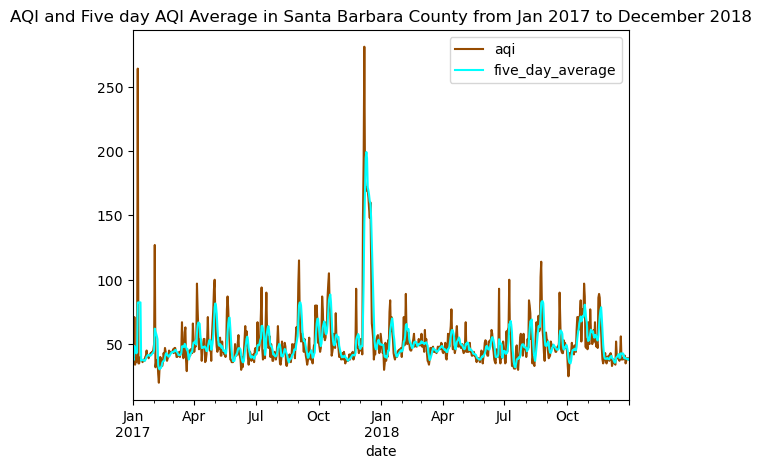

In [43]:
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean() # create new column called 'five_day_average' in aqi_sb data frame that contains a 5 day rolling window
colors = {'aqi': '#964B00', # pick dark brown for aqi
         'five_day_average': 'cyan'}  # pick cyan for five day average
aqi_sb.plot(use_index = True, # include index as x axis
       y = ['aqi','five_day_average'], # plot aqi and five_day_average
       color = colors,
           title = 'AQI and Five day AQI Average in Santa Barbara County from Jan 2017 to December 2018') # have colors be pre defined colors dictionary, add title


##### Can also use Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data to analyze aqi

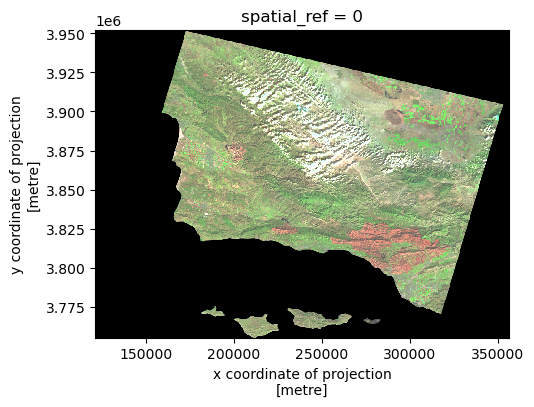

In [48]:
#Create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables.
#select short wave, near infrared, and red variables, make an array and plot with robust = True
landsat_2d[[ 'swir22','nir08', 'red']].to_array().plot.imshow(size = 4, robust = True)

This image looks good, but we want to look closer at the Thomas fire region. We can zoom in on the Thomas fire region to see that the landsat imaage picked up for the region. 

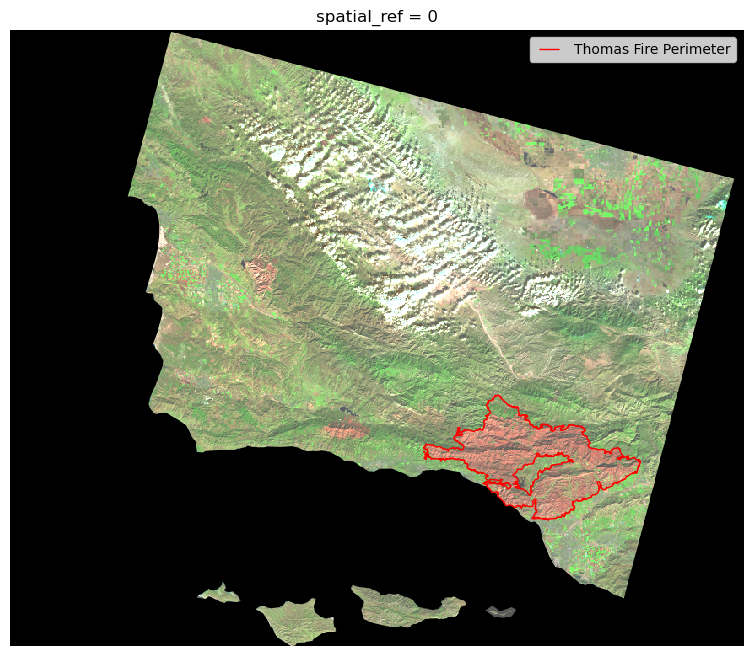

In [52]:
fig, ax = plt.subplots(figsize = (12,8)) # set figure size and axis
ax.axis('off') # turn x and y axis off

# -------------------------
landsat_2d[['swir22','nir08', 'red']].to_array().plot.imshow(ax = ax,robust = True)
thomas_fire.plot(ax = ax,color = 'None', edgecolor = 'red') # plot california map with red outline 
thomas_line = mlines.Line2D([], [], color='red', marker='_', #make legend symbol be a line and change color to red, add label
                          markersize=15, label='Thomas Fire Perimeter', linestyle = 'None')

#---------------------------

# create legend
ax.legend(handles = [thomas_line], frameon = True, loc = 'upper right') # add legend in upper right corner
#---------------------------

plt.show()  # show plot
